In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

from PIL import Image
from nltk.translate import bleu_score

# Import Custom Module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

***

In [4]:
from src.utils.config import IMAGES_DIR
from src.utils.sets import (
    init_image_descriptions_map,
    init_word2idx, init_idx2word,
    load_set_images, init_image_descriptions_set,
    load_image_embedding_map,
    data_generator
)

from src.utils.image import load_image
from src.utils.sequence import clean

from src.nn import NeuralImageCaptioning, NICInference

***

## Understanding and formating the data

In [5]:
image_descriptions = init_image_descriptions_map()

image_descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [6]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [7]:
for img_name, descriptions in image_descriptions.items():
    image_descriptions[img_name] = [clean(descr) for descr in descriptions]

In [8]:
image_descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [9]:
vocabulary = set()

for key in image_descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image_descriptions[key]]

In [10]:
vocabulary.update('0')
vocabulary.update(['<START>'])
vocabulary.update(['<END>'])

In [11]:
print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 8767


### Sort the Vocabulary lexically

In [12]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [13]:
word2idx = init_word2idx(vocabulary)
idx2word = init_idx2word(vocabulary)

In [14]:
word2idx['dog']

2224

In [15]:
idx2word[2224]

'dog'

***

## Max Description Length

In [16]:
descriptions = []

for key, val in image_descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [17]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [18]:
max_description_length = len(longets_description.split()) + 2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 37


***

## Train/Dev/Test split

In [19]:
train_images = load_set_images('train')
dev_images = load_set_images('dev')
test_images = load_set_images('test')

print('Train size: {}'.format(len(train_images)))
print('Dev size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dev size: 1000
Test size: 1000


### Init Image->Descriptions Maps

In [20]:
train_image_descriptions = init_image_descriptions_set(train_images, image_descriptions)
dev_image_descriptions = init_image_descriptions_set(dev_images, image_descriptions)
test_image_descriptions = init_image_descriptions_set(test_images, image_descriptions)

print('Train size: {}'.format(len(train_image_descriptions)))
print('Dev size: {}'.format(len(dev_image_descriptions)))
print('Test size: {}'.format(len(test_image_descriptions)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [21]:
train_image_descriptions['2513260012_03d33305cf']

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

***

## Creating Image-Embedding Maps

In [22]:
train_image_embedding = load_image_embedding_map('train', train_image_descriptions)

Creating "train" Image-Embedding Map...
Instructions for updating:
Colocations handled automatically by placer.
Done.


***

In [25]:
EMBEDDING_DIM = 300
NUM_HIDDEN_NEURONS = [256, 256]

***

# Model

![NIC_model](../../img/NIC.png)

In [26]:
neural_image_captioning = NeuralImageCaptioning(
    EMBEDDING_DIM, max_description_length, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
print(neural_image_captioning.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_embedding_input (InputLay (None, 2048)         0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
top_image_encoder (Model)       (None, 1, 300)       2405676     image_embedding_input[0][0]      
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 37, 8767)     5978899     sequence_input[0][0]             
                                                                 top_image_encoder[1][0]          
Total para

***

# Inference

![LSTM_sampling](../../img/Sampling.png)

***

## Run

### Callbacks

In [29]:
filepath = '../weights/nic-weights.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=True)

# def on_epoch_end(epoch, log):
#     pass

# lambda_callback = LambdaCallback(on_epoch_end=on_epoch_end)


callbacks = [checkpoint]

In [31]:
# neural_image_captioning.model.load_weights('../weights/nic-weights.hdf5')

neural_image_captioning.model.compile(Adam(1e-4), loss='categorical_crossentropy')

In [32]:
num_imgs_per_batch = 8

train_data_generator = data_generator(
    train_image_descriptions,
    train_image_embedding,
    word2idx,
    max_description_length,
    num_imgs_per_batch,
    len(vocabulary),
)
steps = len(train_image_descriptions) // num_imgs_per_batch

neural_image_captioning.model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=steps,
    epochs=100,
    verbose=True,
    callbacks=callbacks,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
750/750 [==============================] - 148s 197ms/step - loss: 5.7448

Epoch 00001: saving model to ../weights/nic-weights.hdf5


/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_decoder_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_decoder_1/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_decoder_1/while/Exit_4:0' shape=(?, 256) dtype=float32>], 'mask': [<tf.Tensor 'sequence_decoder/glove_embeddings/NotEqual:0' shape=(?, 37) dtype=bool>, None, None]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/100
750/750 [==============================] - 165s 220ms/step - loss: 5.2841

Epoch 00002: saving model to ../weights/nic-weights.hdf5
Epoch 3/100
750/750 [==============================] - 162s 216ms/step - loss: 5.1770

Epoch 00003: saving model to ../weights/nic-weights.hdf5
Epoch 4/100
750/750 [==============================] - 162s 216ms/step - loss: 5.1120

Epoch 00004: saving model to ../weights/nic-weights.hdf5
Epoch 5/100
750/750 [==============================] - 160s 214ms/step - loss: 5.0598

Epoch 00005: saving model to ../weights/nic-weights.hdf5
Epoch 6/100
750/750 [==============================] - 161s 214ms/step - loss: 5.0158

Epoch 00006: saving model to ../weights/nic-weights.hdf5
Epoch 7/100
750/750 [==============================] - 161s 214ms/step - loss: 4.9540

Epoch 00007: saving model to ../weights/nic-weights.hdf5
Epoch 8/100
750/750 [==============================] - 161s 214ms/step - loss: 4.8058

Epoch 00008: saving model to ../weights/nic-weigh


Epoch 00058: saving model to ../weights/nic-weights.hdf5
Epoch 59/100
750/750 [==============================] - 157s 209ms/step - loss: 2.6924

Epoch 00059: saving model to ../weights/nic-weights.hdf5
Epoch 60/100
750/750 [==============================] - 156s 208ms/step - loss: 2.6800

Epoch 00060: saving model to ../weights/nic-weights.hdf5
Epoch 61/100
750/750 [==============================] - 156s 207ms/step - loss: 2.6687

Epoch 00061: saving model to ../weights/nic-weights.hdf5
Epoch 62/100
750/750 [==============================] - 157s 209ms/step - loss: 2.6558

Epoch 00062: saving model to ../weights/nic-weights.hdf5
Epoch 63/100
750/750 [==============================] - 156s 208ms/step - loss: 2.6447

Epoch 00063: saving model to ../weights/nic-weights.hdf5
Epoch 64/100
750/750 [==============================] - 156s 208ms/step - loss: 2.6309

Epoch 00064: saving model to ../weights/nic-weights.hdf5
Epoch 65/100
750/750 [==============================] - 155s 206ms/step 

***

## Dev

In [33]:
inference = NICInference(neural_image_captioning, word2idx)

In [34]:
def show_img(path_to_img):
    img = Image.open(path_to_img)
    img.load()
    plt.imshow(np.asarray(img, dtype='int32'));

def evaluate(img_id, beam_width=3):
    print('Image ID: {}'.format(img_id))
    print('='*50)
    print()
    img = load_image(img_id)
    
    greedy_hypothesis = inference.greedy_search(img)
    beam_hypothesis = inference.beam_search(img, beam_width=beam_width)
    references = image_descriptions[img_id]

    print('Greedy Search: {}'.format(greedy_hypothesis))
    print('Beam Search: {}'.format(beam_hypothesis))
    print()
    
    print('BLEU score Greedy Search: {}'.format(bleu_score.sentence_bleu(references, greedy_hypothesis)))
    print('BLEU score Beam Search: {}'.format(bleu_score.sentence_bleu(references, beam_hypothesis)))
    print()
    
    print('Greedy Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, greedy_hypothesis)))
    print('Beam Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, beam_hypothesis)))
    
    show_img(IMAGES_DIR+img_id+'.jpg')

Image ID: 2273038287_3004a72a34

Greedy Search: a black dog is running through the grass
Beam Search: a black dog is running on the grass

BLEU score Greedy Search: 0.7106330012036549
BLEU score Beam Search: 0.8063341749364832

Greedy Search Hypothesis Log Probabilty: -50.956939697265625
Beam Search Hypothesis Log Probabilty: -50.56914520263672


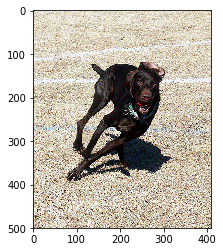

In [35]:

evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=10
)

Image ID: 2090327868_9f99e2740d

Greedy Search: a woman in a white dress is standing in front of a white and white wall
Beam Search: a woman in a red and a boy in white

BLEU score Greedy Search: 0.6290736262873894
BLEU score Beam Search: 0.3335995564235203

Greedy Search Hypothesis Log Probabilty: -124.75227355957031
Beam Search Hypothesis Log Probabilty: -81.37598419189453


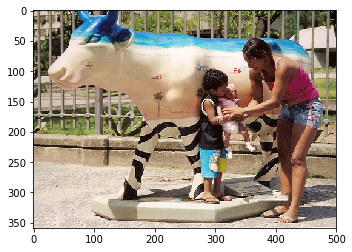

In [36]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=10
)

Image ID: 3354075558_3b67eaa502

Greedy Search: a cat is licking its head on a red carpet
Beam Search: a black and a woman

BLEU score Greedy Search: 0.7381610378359039
BLEU score Beam Search: 0.2618764939810402

Greedy Search Hypothesis Log Probabilty: -57.74415969848633
Beam Search Hypothesis Log Probabilty: -35.124027252197266


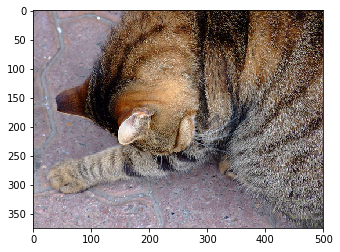

In [37]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=50
)

Image ID: 3285180819_a9712fd2bc

Greedy Search: a basketball player in a white uniform is dribbling the ball
Beam Search: a basketball player dribbles basketball

BLEU score Greedy Search: 0.6956341974004442
BLEU score Beam Search: 0.6153577614528986

Greedy Search Hypothesis Log Probabilty: -74.54657745361328
Beam Search Hypothesis Log Probabilty: -27.415897369384766


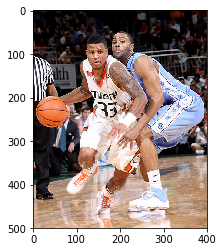

In [38]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=50
)

Image ID: 3228517564_74b00a923b

Greedy Search: a man on a bike is jumping over a dirt hill
Beam Search: a person on a dirt bike

BLEU score Greedy Search: 0.5846275524370601
BLEU score Beam Search: 0.7424740563395944

Greedy Search Hypothesis Log Probabilty: -73.4874267578125
Beam Search Hypothesis Log Probabilty: -34.6462516784668


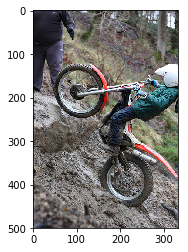

In [39]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=100
)

Image ID: 2965604928_435dc93bf7

Greedy Search: a dog runs in a field
Beam Search: a dog is running

BLEU score Greedy Search: 0.788127627745311
BLEU score Beam Search: 0.41431609618675985

Greedy Search Hypothesis Log Probabilty: -40.812870025634766
Beam Search Hypothesis Log Probabilty: -23.20436668395996


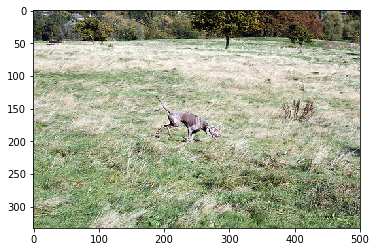

In [40]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=100
)